In [1]:
## 기본 library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
## model library
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from keras import models, layers
## helper library
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score


data = pd.read_csv('../1.clustering/titanic.csv')

target = data['Survived']
data = data.drop(['PassengerId', 'Survived'], axis=1)

Using TensorFlow backend.


In [2]:
d = data.copy()
categorical = [
    'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked'
]

In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

data['Age'] = pd.DataFrame(MinMaxScaler().fit_transform(data['Age'].values.reshape(-1,1)))
data['Fare'] = pd.DataFrame(StandardScaler().fit_transform(data['Fare'].values.reshape(-1,1)))

lbe = LabelEncoder()
data['Sex'] = lbe.fit_transform(data['Sex'])
sex = lbe.classes_
data['Embarked'] = lbe.fit_transform(data['Embarked'])
emb = lbe.classes_

for c in categorical:
    data = pd.concat([data, pd.get_dummies(data[c], prefix=c)], axis=1)
    data = data.drop(c, axis=1)

In [4]:
train_X, test_X, train_y, test_y = train_test_split(data, target, test_size=0.3, random_state=0, shuffle=True)

In [5]:
kfold = KFold(n_splits=10, shuffle=True, random_state=0)

In [6]:
## logistic
acc = 0
for tr_idx, val_idx in kfold.split(train_X):
    tr_X, tr_y = train_X.iloc[tr_idx, :], train_y.iloc[tr_idx]
    val_X, val_y = train_X.iloc[val_idx, :], train_y.iloc[val_idx]
    lr = LogisticRegression(random_state=0).fit(tr_X, tr_y)
    acc += accuracy_score(val_y, lr.predict(val_X))/10

print(acc)

0.799265306122449


In [7]:
## 조금 더 간단히 할 수 있음
lr  = LogisticRegression(random_state=0)
acc = cross_val_score(lr, train_X, train_y, cv=kfold, n_jobs=1, scoring='accuracy')
print(np.mean(acc))

0.7992653061224491


In [8]:
lr = LogisticRegression(random_state=0).fit(train_X, train_y)

In [9]:
## knn
opt = []
for n in range(2, 30):
    knn = KNeighborsClassifier(n_neighbors=n)
    acc = []
    for tr_idx, val_idx in kfold.split(train_X):
        tr_X, tr_y = train_X.iloc[tr_idx, :], train_y.iloc[tr_idx]
        val_X, val_y = train_X.iloc[val_idx, :], train_y.iloc[val_idx]
        knn.fit(tr_X, tr_y)
        acc.append(accuracy_score(val_y, knn.predict(val_X)))
    opt.append(np.mean(acc))

[0.7811020408163265, 0.8093061224489796, 0.7791836734693878, 0.7951428571428572, 0.7952653061224491, 0.7953469387755102, 0.7973469387755102, 0.7953061224489797, 0.8033061224489797, 0.7952244897959184, 0.7972244897959184, 0.793265306122449, 0.7892653061224489, 0.7933469387755101, 0.8053469387755102, 0.8053877551020407, 0.7933061224489796, 0.7973469387755102, 0.7893469387755102, 0.8013061224489796, 0.7853469387755101, 0.7953877551020407, 0.7913877551020408, 0.7953061224489797, 0.7893469387755102, 0.7892653061224489, 0.7892244897959183, 0.791265306122449]


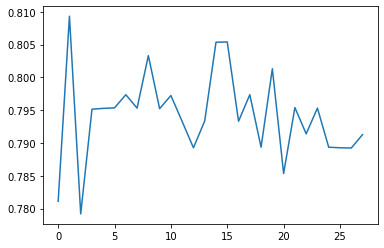

In [10]:
plt.plot(opt)
print(opt)


In [11]:
## knn's n_neighbor = 3
knn = KNeighborsClassifier(n_neighbors=3).fit(train_X, train_y)

In [12]:
## RF with no paramter tuning
from sklearn.ensemble import RandomForestClassifier

acc = 0
for tr_idx, val_idx in kfold.split(train_X):
    tr_X, tr_y = train_X.iloc[tr_idx, :], train_y.iloc[tr_idx]
    val_X, val_y = train_X.iloc[val_idx, :], train_y.iloc[val_idx]
    rf = RandomForestClassifier(random_state=0).fit(tr_X, tr_y)
    acc += accuracy_score(val_y, rf.predict(val_X))/10

print(acc)

0.7832653061224489


In [13]:
rf = RandomForestClassifier(random_state=0).fit(train_X, train_y)

In [22]:
## xgboost
from bayes_opt import BayesianOptimization

xgb_bounds = {
    'max_depth': (3, 12),
    'subsample': (0.3, 1),
    'colsample_bytree': (0.3, 1),
    'reg_alpha': (0.1, 3),
    'reg_lamda': (0.1, 3)
}

best_ns = []

def bayes_xgb(max_depth, subsample, colsample_bytree, reg_alpha, reg_lamda):
    global best_ns
    params = {
        'n_estimators': 1000,
        'booster': 'gbtree',
        'tree_method': 'hist',
        'random_state': 0,
        'n_jobs': -1,
        'max_depth': int(max_depth),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'reg_alpha': reg_alpha,
        'reg_lamda': reg_lamda
    }
    
    acc = 0
    best_n = 0
    for tr_idx, val_idx in kfold.split(train_X):
        tr_X, tr_y = train_X.iloc[tr_idx, :], train_y.iloc[tr_idx]
        val_X, val_y = train_X.iloc[val_idx, :], train_y.iloc[val_idx]
        clf = XGBClassifier(**params).fit(tr_X, tr_y, eval_metric = 'error', eval_set=[[val_X, val_y]], early_stopping_rounds=100, verbose=0)
        acc += accuracy_score(val_y, clf.predict(val_X))/10
        best_n += clf.best_iteration/10
    best_ns.append(best_n)
    return acc

In [23]:
%%time
optimizer = BayesianOptimization(bayes_xgb, xgb_bounds, random_state=0)

init_points = 10
n_iter = 20

optimizer.maximize(init_points=init_points, n_iter=n_iter)

|   iter    |  target   | colsam... | max_depth | reg_alpha | reg_lamda | subsample |
-------------------------------------------------------------------------------------
|  1        |  0.8475   |  0.6842   |  9.437    |  1.848    |  1.68     |  0.5966   |
|  2        |  0.8536   |  0.7521   |  6.938    |  2.686    |  2.895    |  0.5684   |
|  3        |  0.8475   |  0.8542   |  7.76     |  1.747    |  2.784    |  0.3497   |
|  4        |  0.8454   |  0.361    |  3.182    |  2.515    |  2.357    |  0.909    |
|  5        |  0.8555   |  0.985    |  10.19    |  1.438    |  2.364    |  0.3828   |
|  6        |  0.8475   |  0.7479   |  4.29     |  2.84     |  1.613    |  0.5903   |
|  7        |  0.8556   |  0.4852   |  9.968    |  1.423    |  1.748    |  0.3132   |
|  8        |  0.8456   |  0.7323   |  8.509    |  1.889    |  2.837    |  0.7773   |
|  9        |  0.8415   |  0.5517   |  6.933    |  2.123    |  0.2747   |  0.7667   |
|  10       |  0.8616   |  0.7694   |  4.893    |  0.4

In [26]:
optimizer.max['params']

In [35]:
best_params = {
    'n_estimators': int(best_ns[26]),
    'booster': 'gbtree',
    'tree_method': 'hist',
    'random_state': 0,
    'n_jobs': -1,
    'max_depth': int(optimizer.max['params']['max_depth']),
    'subsample': optimizer.max['params']['subsample'],
    'colsample_bytree': optimizer.max['params']['colsample_bytree'],
    'reg_alpha': optimizer.max['params']['reg_alpha'],
    'reg_lamda': optimizer.max['params']['reg_lamda'],
    'metric': 'error'
}

clf = XGBClassifier(**best_params).fit(train_X, train_y)


In [36]:
## voting
from sklearn.ensemble import VotingClassifier

v_lr = LogisticRegression(random_state=0)
v_knn = KNeighborsClassifier(n_neighbors=3)
v_rf = RandomForestClassifier(max_depth=9, random_state=0)

vclf = VotingClassifier(estimators=[
    ('lr', v_lr),
    ('knn', v_knn),
    ('rf', v_rf)
], voting='soft')

acc = 0
for tr_idx, val_idx in kfold.split(train_X):
    tr_X, tr_y = train_X.iloc[tr_idx, :], train_y.iloc[tr_idx]
    val_X, val_y = train_X.iloc[val_idx, :], train_y.iloc[val_idx]
    vclf.fit(tr_X, tr_y)
    acc += accuracy_score(val_y, vclf.predict(val_X))/10

print(acc)

0.8073061224489797


개별 모델들과 앙상블모형을 통틀어 xgboost가 가장 높은 성능을 보여줄 것으로 기대된다.  
실제 test셋의 결과는 어떨까?


In [37]:
print('lr:', accuracy_score(test_y, lr.predict(test_X)))
print('knn:', accuracy_score(test_y, knn.predict(test_X)))
print('rf:', accuracy_score(test_y, rf.predict(test_X)))
print('xgboost:', accuracy_score(test_y, clf.predict(test_X)))
print('voting:', accuracy_score(test_y, vclf.predict(test_X)))

lr: 0.7710280373831776
knn: 0.7523364485981309
rf: 0.7663551401869159
xgboost: 0.780373831775701
voting: 0.7897196261682243


voting이 가장 높은 정확도를 보여준다.  
xgboost같은 경우 과적합이 심하게 되어 test에서 그 성능이 제대로 나오지 않았다.  
역시 voting의 경우 robust한 것인가를 느낄 수 있었다.